# Devotees prediction for Dharmshala using Time Series Analysis


#  - Problem Statement:

Create a time series analysis system to predict Devotees/ customer demand for hotels/ Dharmshala near temples. 
Develop models that utilize temporal patterns and historical data to forecast occupancy rates, 
allowing hotel owners to optimize pricing, staffing, and amenities to meet anticipated demand. 
Address challenges such as seasonality, sudden spikes in visitors during festivals, and other factors 
influencing hotel bookings near religious sites.

# - Business Objectives:
To predict the count of devotees to arrive in Dharmshala .
Minimize:  Prediction Error & Resource Utilization
Maximize: Accuracy in prediction  & Devotees satisfaction

# Imports libraries 


In [1]:
import sweetviz as sv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose # tsa = Time series
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pickle
from sklearn.metrics import mean_squared_error
import numpy as np
import os



In [2]:
df= pd.read_excel('Saidham.3.xlsx', index_col='Date', parse_dates = True)
df.head()


,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1,1,2023
2023-01-02,231,2,1,2023
2023-01-03,116,3,1,2023
2023-01-04,114,4,1,2023
2023-01-05,223,5,1,2023


In [3]:
df.tail
df.dtypes

Total_Customer    int64
day               int64
month             int64
year              int64
dtype: object

In [4]:
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year


# Find and remove outliers


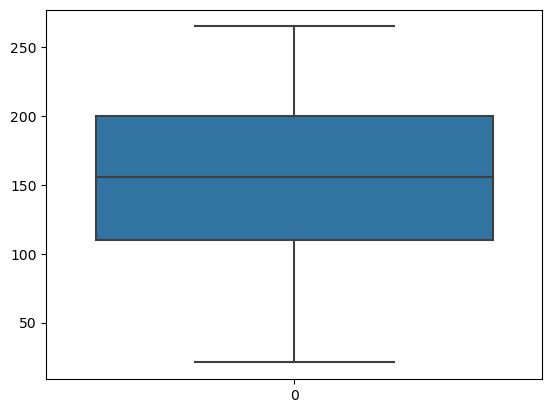

In [5]:


sns.boxplot(df.Total_Customer)
#sns.boxplot(df.day)
#sns.boxplot(df.month)
#sns.boxplot(df.year)

    
data_list = ['Total_Customer','day', 'month', 'year']

In [6]:

data_list = ['Total_Customer','day', 'month', 'year']

for data in data_list:
    IQR = df[data].quantile(0.75) - df[data].quantile(0.25)
    lower_limit = df[data].quantile(0.25) - (IQR * 1.5)
    if lower_limit < 0:
        lower_limit = 0.0
    upper_limit = df[data].quantile(0.75) + (IQR * 1.5)
    outliers_df = np.where((df[data] > upper_limit) | (df[data] < lower_limit), True, False)
    print(f'There are {outliers_df.sum()} outliers in {data} column.', '\n')

There are 0 outliers in Total_Customer column. 

There are 0 outliers in day column. 

There are 0 outliers in month column. 

There are 0 outliers in year column. 



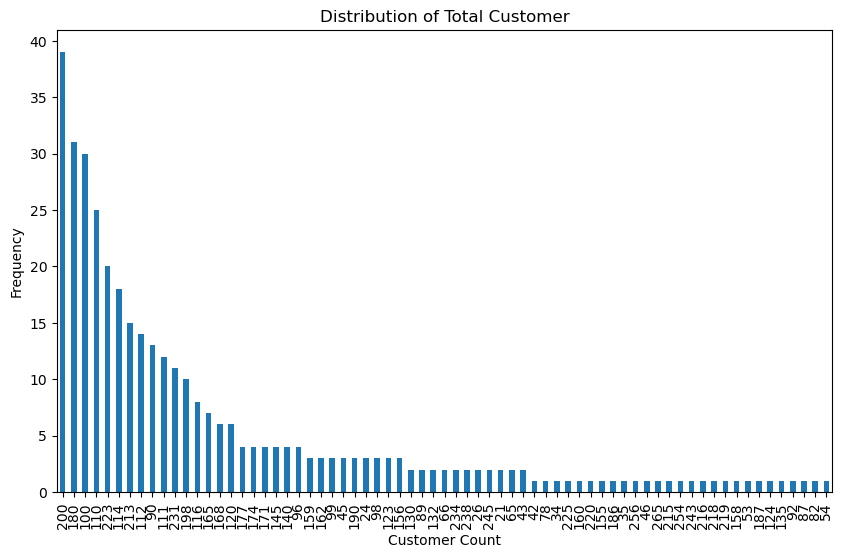

In [7]:
#checking  how many times each 
df['Total_Customer'].value_counts().plot(kind='bar',figsize=(10, 6))
# Optionally, you can add labels and a title for better readability
plt.xlabel('Customer Count')
plt.ylabel('Frequency')
plt.title('Distribution of Total Customer')

# Show the plot
plt.show()


In [8]:
 #Checking missing values in train data set
df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()

Total_Customer    0
day               0
month             0
year              0
dtype: int64

In [9]:
#Check if any zero value in dataset

for Total_Customer in data_list:
    print(f'{df[(df[Total_Customer]==0)].shape[0]} times of {Total_Customer} is 0.', '\n')

0 times of Total_Customer is 0. 

0 times of day is 0. 

0 times of month is 0. 

0 times of year is 0. 



In [10]:
#pd.plotting.register_matplotlib_converters()

# these converters just make sure that for example
#datetime.datetime gets overwritten by pandas.Timestamp, 
#allowing for compatibility with pandas. Maybe this will 
#help: it seems that there is another method called 
#deregister_matplotlib_converters

# Exploratory Data Analysis (EDA)

In [11]:
def EDA():
   #analyzing the dataset
    eda_report = sv.analyze(df)
   #display the report
    eda_report.show_html('eda1.html')
   #Let us check the outliers in the data

<Axes: >

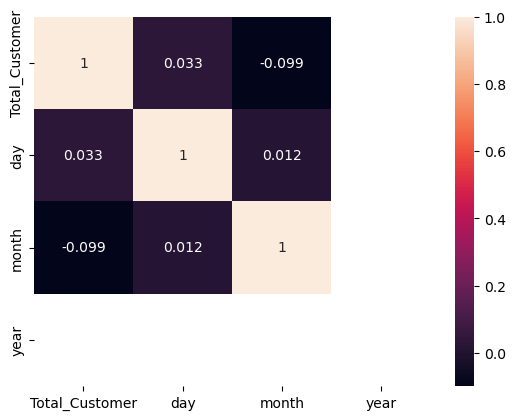

In [12]:
#Correlation Analysis
#plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(),annot=True)

#We can see a strong negative correlation between temp_max.temp_min,wind,precipitation,day,month,year

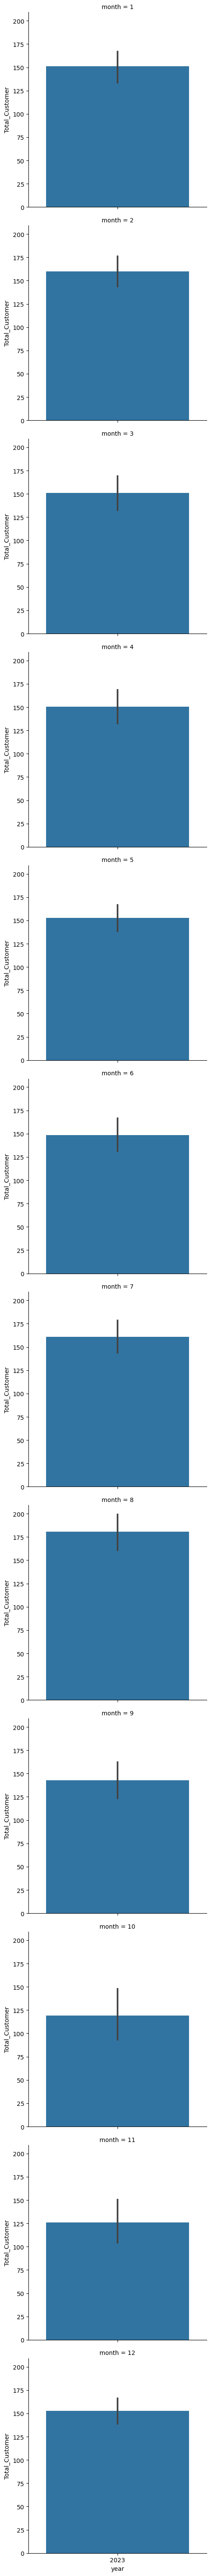

In [13]:
#Catplot of each month
sns.catplot(data=df, x="year", y="Total_Customer", row="month", kind="bar")


In [14]:
df

,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1,1,2023
2023-01-02,231,2,1,2023
2023-01-03,116,3,1,2023
2023-01-04,114,4,1,2023
2023-01-05,223,5,1,2023
...,...,...,...,...
2023-12-27,110,27,12,2023
2023-12-28,180,28,12,2023
2023-12-29,200,29,12,2023


In [15]:
# Assigning one col from each category
plot_a = df.Total_Customer
plot_b = df.day
plot_c = df.month
plot_d = df.year


### Resampling Columns 

<Axes: xlabel='Date'>

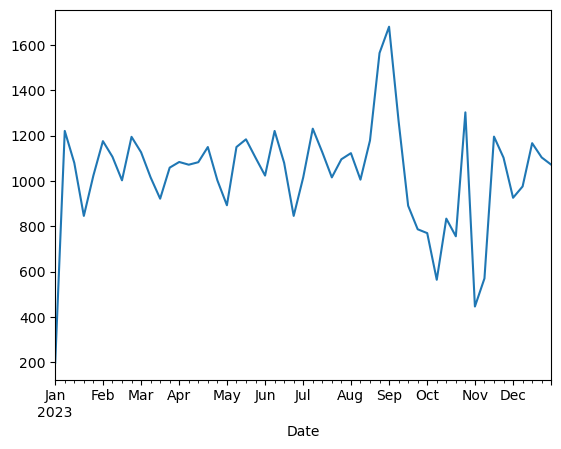

In [16]:
# Now, you can use the resample method
plot_a = df['Total_Customer']
plot_a.resample('W').sum().plot()

<Axes: xlabel='Date'>

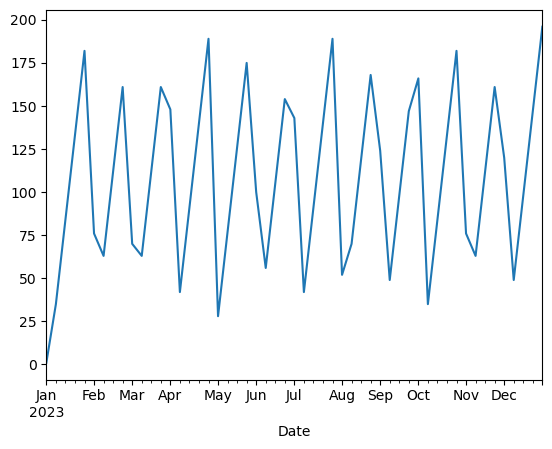

In [17]:
plot_b = df['day']
plot_b.resample('W').sum().plot()
#values in plot_b is resampled.

<Axes: xlabel='Date'>

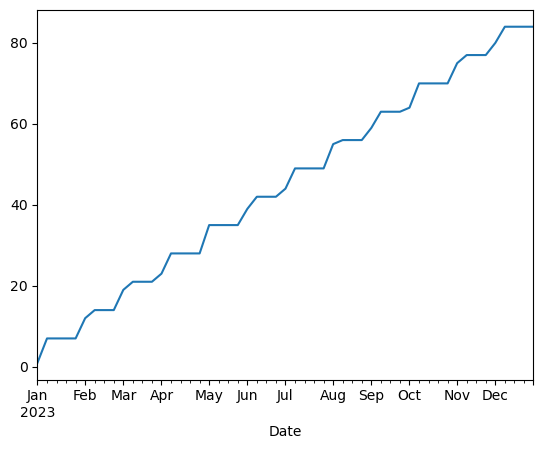

In [18]:
plot_c = df['month']
plot_c.resample('W').sum().plot()
#values in plot_c is resampled by week

<Axes: xlabel='Date'>

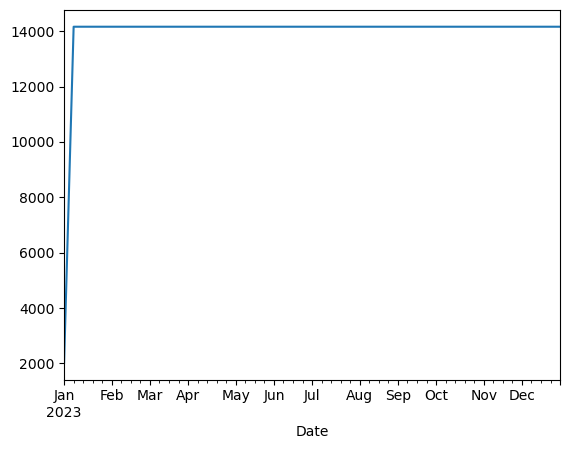

In [19]:
plot_d = df['year']
plot_d.resample('W').sum().plot()
#values in plot_d is resampled by week


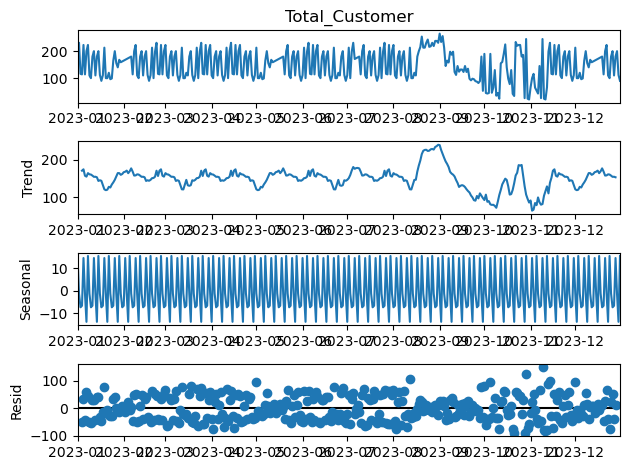

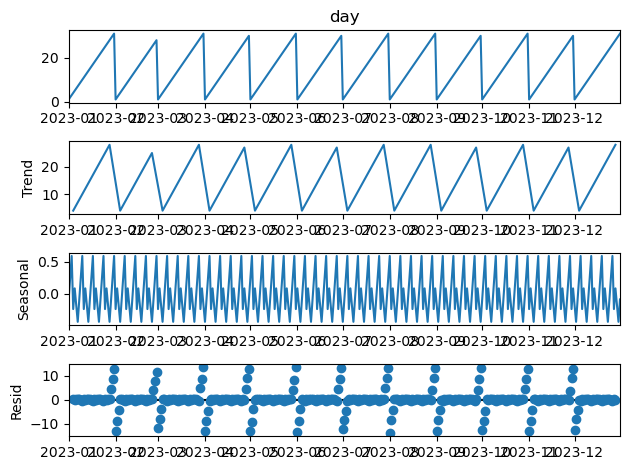

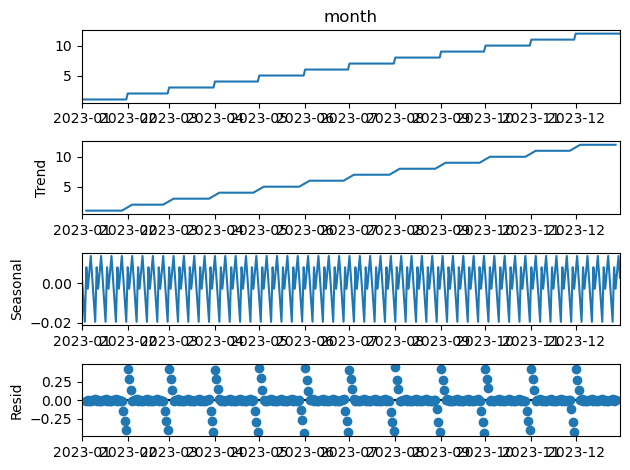

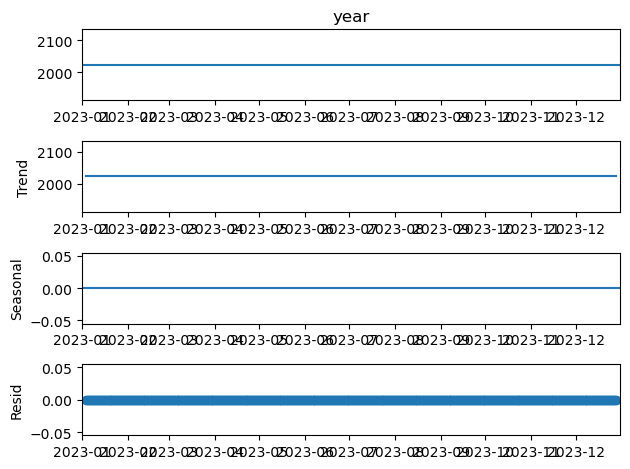

In [20]:
#Time Series Decomposition
#Four kinds of components help make a time series, and also
#they can affect our time series analysis if present in 
#excess. So here, for this time series
#we need to check more for the availability of components.

#Time series decomposition is a technique that splits a 
#time series into several components, each representing an
#underlying pattern category. These components are level, 
#trend, seasonality, ( All three are systematic components) and noise (Non-systematic component of the time series).

#level: The average of data.

#Seasonality: describes the periodic signal in your time series.

#Trend: describes Cusomer the time series is decreasing, 
#       constant, or increasing over time.

#Noise: describes what remains behind the separation of 
#        seasonality and trend from the time series. 
 
for data in data_list:
    decompose_ts_add = seasonal_decompose(df[data], model="additive", period=7)  # assuming weekly seasonality
    decompose_ts_add.plot()


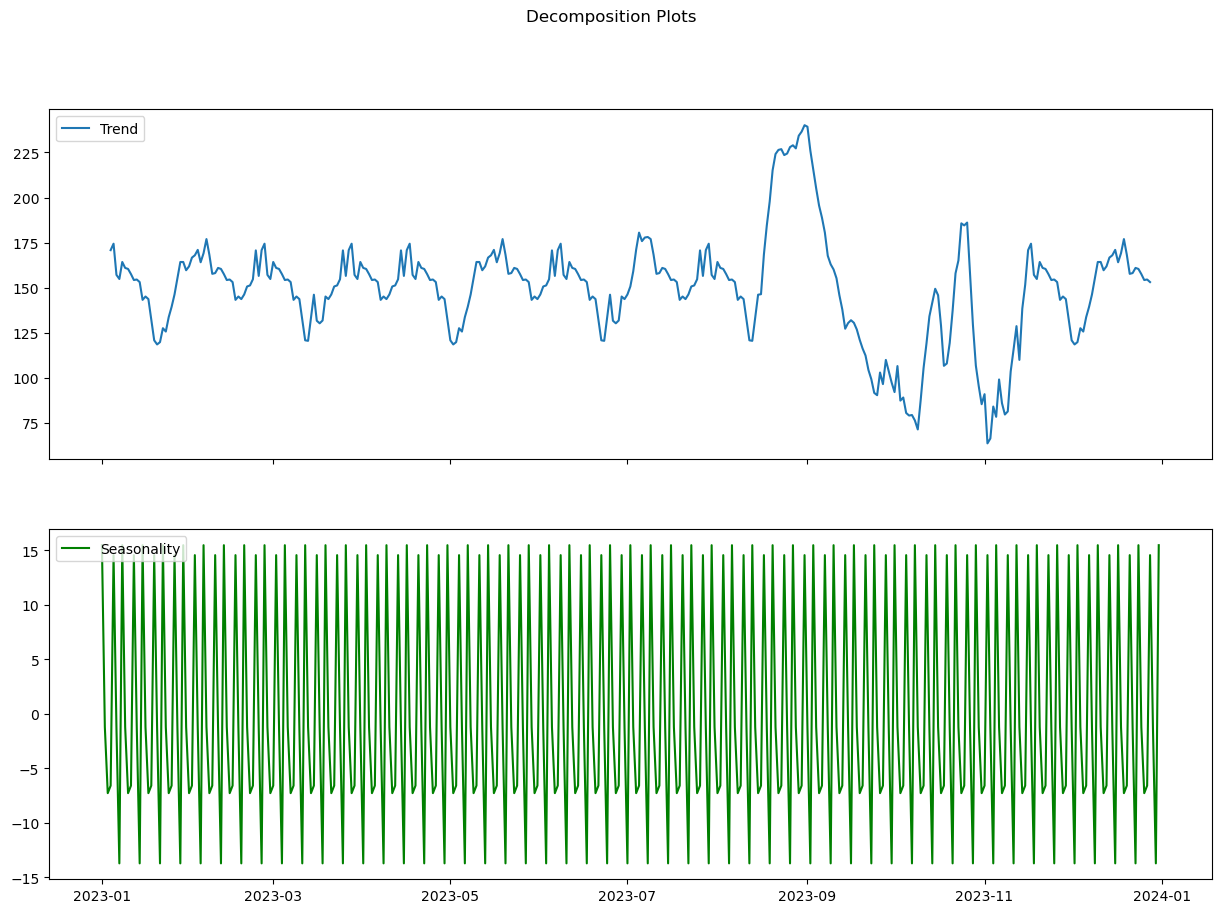

In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_timeseries(sales):
    # Creating subplots
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    
    # Setting figure size
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    # Decomposing the time series
    decomposition = seasonal_decompose(sales, model='additive', period=7)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    # Plotting seasonality
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    
    # Plotting trend
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    # Adding a title to the figure
    fig.suptitle('Decomposition Plots')

# Example usage:
# Assuming plot_a is your time series data
plot_timeseries(plot_a)


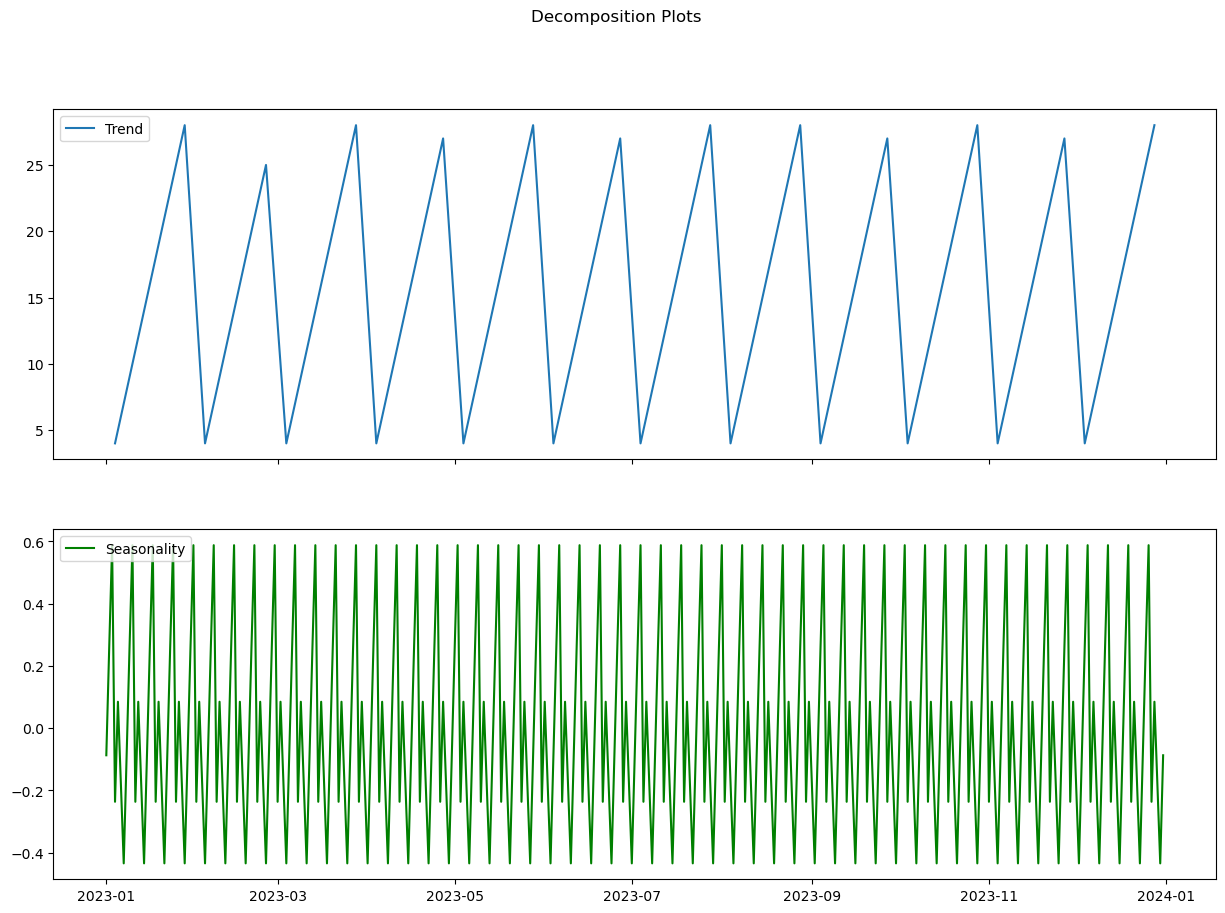

In [22]:
plot_timeseries(plot_b)

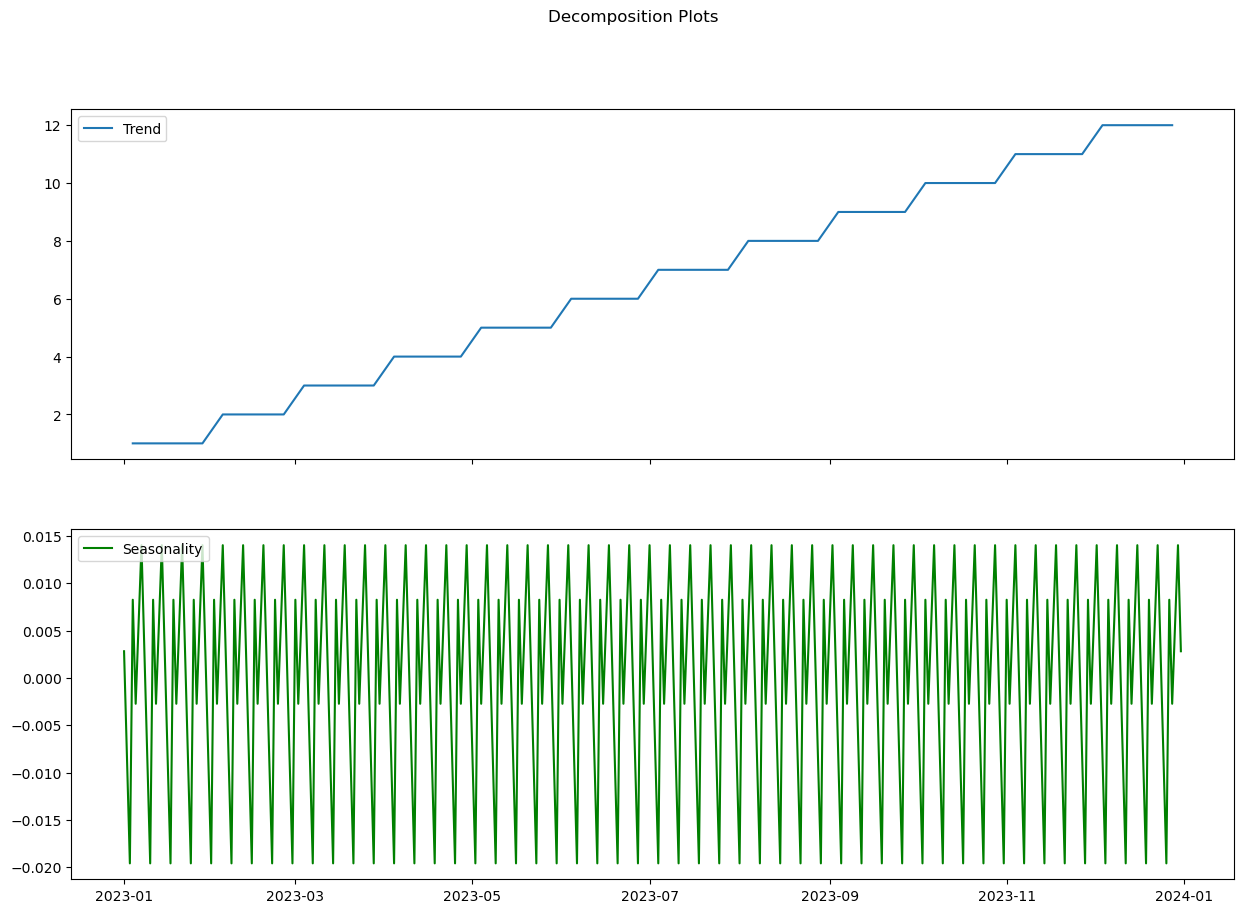

In [23]:
plot_timeseries(plot_c)


In [24]:
'''#Drop 
df[data].dropna(inplace=True)
'''

'#Drop \ndf[data].dropna(inplace=True)\n'

#### adfuller Testing for finding p-value

In [25]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
def test_stationarity(time_series):
        #Determining rolling statiststics
        roll_mean=time_series.rolling(window=7).mean()
        roll_std=time_series.rolling(window=7).std()
        #plotting rolling statistics
        orig=plt.plot(time_series.resample('W').mean(),color='blue',label='original')
        mean=plt.plot(roll_mean.resample('W').mean(),color='red',label='Rolling mean')
        std=plt.plot(roll_std.resample('W').mean(),color='green',label='Rolling standard')
        plt.legend(loc='best')
        plt.show(block=False)
        #performance of Dicky fuller test
time_series = np.random.randn(100) 
print("Result of Dicky fuller test")
result=adfuller(time_series,autolag='AIC')
print("ADF statistics: %f"%result[0])
print("p-value:   %f"%result[1])
print("critical values")
for key,value in result[4].items():
        print(key,value)

Result of Dicky fuller test
ADF statistics: -9.378980
p-value:   0.000000
critical values
1% -3.498198082189098
5% -2.891208211860468
10% -2.5825959973472097


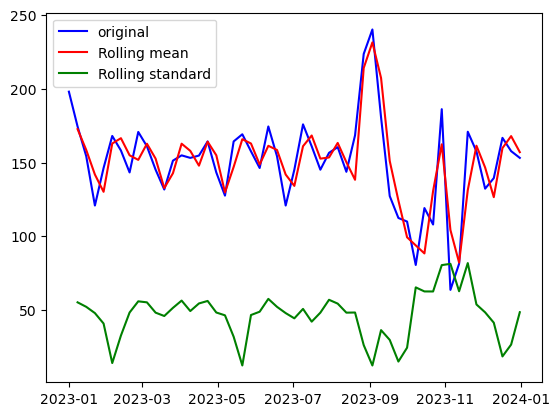

In [26]:
test_stationarity(plot_a)

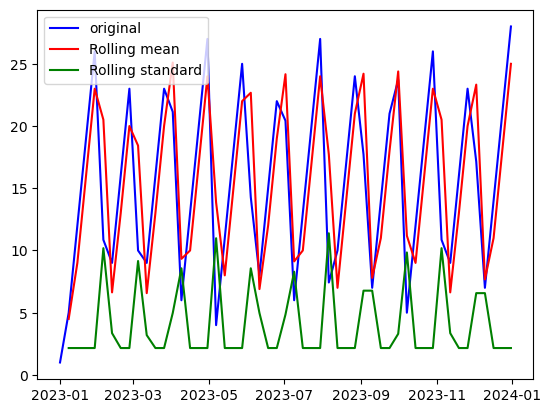

In [27]:
 test_stationarity(plot_b)

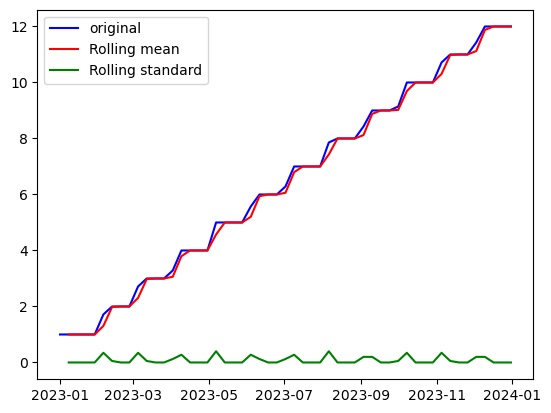

In [28]:
test_stationarity(plot_c)

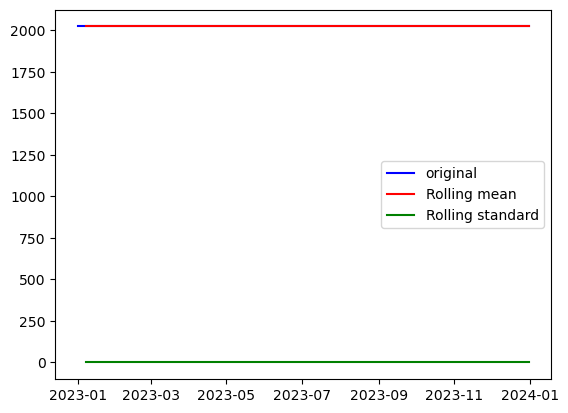

In [29]:
 test_stationarity(plot_d)

#We can see from the above plots and statistical tests 
#that mean and variation doesn't change much with time, 
#i.e they are constant. Thus, we don't need to perform any
#transformation (needed when time series is not stationary)

## Data preparation

<Axes: >

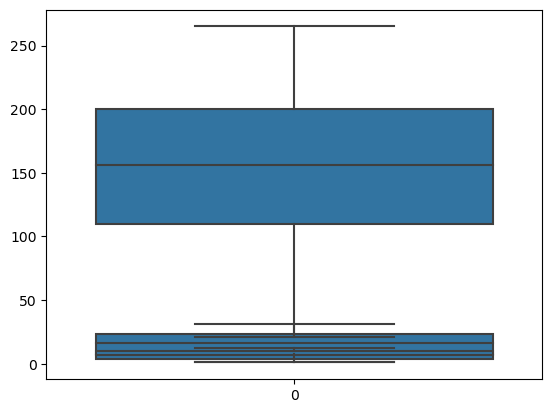

In [30]:
#Data preparation
from feature_engine.outliers import Winsorizer

winsor=Winsorizer(capping_method='iqr',tail='both',fold=1.5,variables=['Total_Customer','day', 'month'])
df_t=winsor.fit_transform(df[['Total_Customer','day', 'month']]) 

sns.boxplot(df_t.Total_Customer)
sns.boxplot(df_t.day) 
sns.boxplot(df_t.month)
#sns.boxplot(df_t.year)

In [31]:
#  Dropping Duplicate data 
df.drop_duplicates()

,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1,1,2023
2023-01-02,231,2,1,2023
2023-01-03,116,3,1,2023
2023-01-04,114,4,1,2023
2023-01-05,223,5,1,2023
...,...,...,...,...
2023-12-27,110,27,12,2023
2023-12-28,180,28,12,2023
2023-12-29,200,29,12,2023


In [32]:
df['Total_Customer_Max'] = df['Total_Customer'].expanding().max()
df['Total_Customer_Min'] = df['Total_Customer'].expanding().min()
df['Total_Customer_Avg']= df['Total_Customer'].expanding().mean()
df['Total_Customer_std']= df['Total_Customer'].expanding().std()
df['Total_Customer_count']= df['Total_Customer'].expanding().count()
df['Total_Customer_present']= 1
df['Total_Customer_absent']= 0

df.columns


Index(['Total_Customer', 'day', 'month', 'year', 'Total_Customer_Max',
       'Total_Customer_Min', 'Total_Customer_Avg', 'Total_Customer_std',
       'Total_Customer_count', 'Total_Customer_present',
       'Total_Customer_absent'],
      dtype='object')

In [33]:
#  Dropping missing data 
df.isna().sum()
df.dropna(axis =0,inplace= True)
     

# Training,testing and spliting 

### Liner Regression Model

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Example data (replace this with your actual data loading or generation)
X_normalized = np.random.rand(365, 10)  # Assuming 365 samples and 10 features
y = np.random.rand(365)  # Assuming 365 samples for the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Train a model (linear regression for this example)
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE on normalized data
rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error (RMSE) on normalized data:", rmse)




Root Mean Squared Error (RMSE) on normalized data: 0.2958280515467336


In [35]:
X_test

array([[8.74351444e-01, 4.47086134e-01, 6.43089806e-02, 8.09597360e-01,
        4.39951614e-01, 3.38761004e-02, 7.02432704e-01, 4.49692170e-01,
        6.57572486e-01, 5.99184452e-01],
       [6.10384197e-01, 3.01219606e-01, 9.50387875e-01, 5.66814874e-01,
        9.52218971e-01, 7.74700843e-01, 7.50285072e-01, 6.58781679e-01,
        1.09897977e-01, 6.29033750e-01],
       [9.04570693e-01, 6.38530700e-01, 3.24022203e-01, 7.04268717e-01,
        2.31832488e-01, 9.73811276e-01, 1.10938048e-01, 5.79590530e-01,
        9.17672455e-02, 7.52426039e-02],
       [9.85859500e-01, 1.85405873e-01, 1.48929201e-01, 5.44711834e-01,
        6.56063735e-01, 7.97815509e-02, 2.20093358e-01, 7.98716503e-01,
        5.09038747e-01, 7.87774636e-01],
       [9.39278559e-01, 4.84183154e-01, 6.08874298e-01, 7.00790397e-01,
        1.87267408e-01, 2.06554140e-01, 9.96379820e-01, 4.48218134e-01,
        9.95156913e-01, 2.36946524e-01],
       [9.52600276e-01, 4.26684305e-01, 7.06405838e-01, 5.80301070e-02,
   

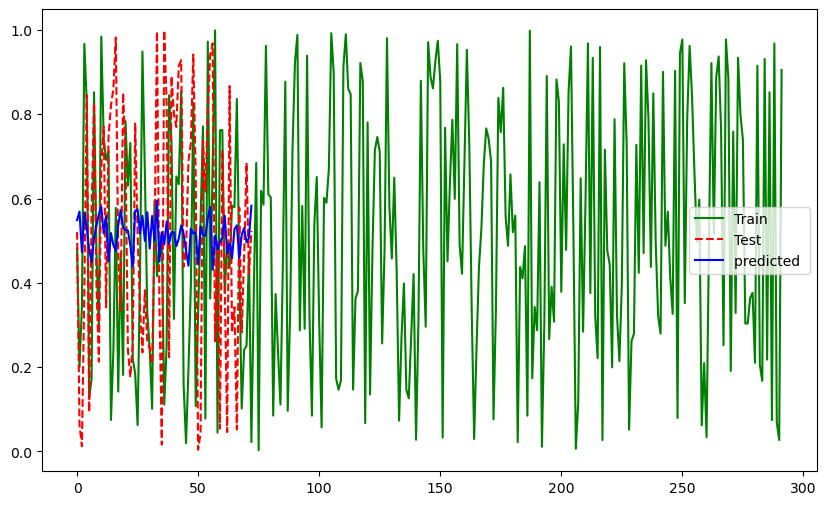

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Train', linestyle='-', color='g')
plt.plot(y_test, label='Test', linestyle='--', color='r')
plt.plot(y_pred, label='predicted ', linestyle='-', color='b')
plt.legend()
plt.show()

In [37]:
df

,Total_Customer,day,month,year,Total_Customer_Max,Total_Customer_Min,Total_Customer_Avg,Total_Customer_std,Total_Customer_count,Total_Customer_present,Total_Customer_absent
Date,,,,,,,,,,,
2023-01-02,231,2,1,2023,231.0,198.0,214.500000,23.334524,2.0,1,0
2023-01-03,116,3,1,2023,231.0,116.0,181.666667,59.214300,3.0,1,0
2023-01-04,114,4,1,2023,231.0,114.0,164.750000,59.010592,4.0,1,0
2023-01-05,223,5,1,2023,231.0,114.0,176.400000,57.361137,5.0,1,0
2023-01-06,114,6,1,2023,231.0,114.0,166.000000,57.281760,6.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,110,27,12,2023,265.0,21.0,149.734072,54.688219,361.0,1,0
2023-12-28,180,28,12,2023,265.0,21.0,149.817680,54.635584,362.0,1,0
2023-12-29,200,29,12,2023,265.0,21.0,149.955923,54.623606,363.0,1,0


In [38]:
X_future = df[['Total_Customer','day','month','year','Total_Customer_Min','Total_Customer_Min','Total_Customer_Avg','Total_Customer_present',
       'Total_Customer_absent', 'Total_Customer_std']].tail(7)
X_future 



,Total_Customer,day,month,year,Total_Customer_Min,Total_Customer_Min,Total_Customer_Avg,Total_Customer_present,Total_Customer_absent,Total_Customer_std
Date,,,,,,,,,,
2023-12-25,180,25,12,2023,21.0,21.0,149.704735,1,0,54.736104
2023-12-26,200,26,12,2023,21.0,21.0,149.844444,1,0,54.724056
2023-12-27,110,27,12,2023,21.0,21.0,149.734072,1,0,54.688219
2023-12-28,180,28,12,2023,21.0,21.0,149.817680,1,0,54.635584
2023-12-29,200,29,12,2023,21.0,21.0,149.955923,1,0,54.623606
2023-12-30,112,30,12,2023,21.0,21.0,149.851648,1,0,54.584582
2023-12-31,90,31,12,2023,21.0,21.0,149.687671,1,0,54.599501


# Prediction in next 7 days using LR model

In [39]:
# Predict the number of customers for the next 7 days
y_future_pred = model.predict(X_future)

#print("Predicted number of customers for the next 7 days:", y_future_pred)

import pandas as pd

# Assuming X_future has a datetime index
# If not, create a date range for the next 7 days starting from January 1, 2024
date_range = pd.date_range(start='2024-01-01', periods=7)

# Create a DataFrame with the dates and predicted values
predictions_df = pd.DataFrame({'Predicted_Customers': y_future_pred}, index=date_range)

# Display the DataFrame with the desired format
print("Predicted number of customers for the next 7 days:")
print(predictions_df.abs())


Predicted number of customers for the next 7 days:
            Predicted_Customers
2024-01-01           167.752346
2024-01-02           167.785844
2024-01-03           167.229401
2024-01-04           167.530191
2024-01-05           167.563699
2024-01-06           167.017850
2024-01-07           166.828433


<Axes: >

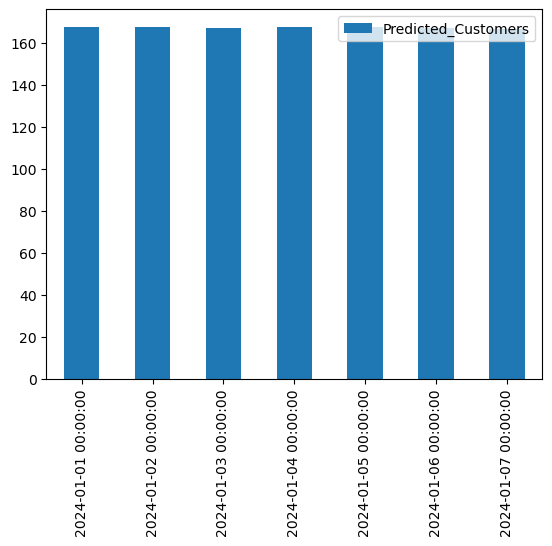

In [40]:
predictions_df.plot(kind='bar')

In [41]:
# Example data (replace this with your actual data loading or generation)
X_normalized = np.random.rand(365, 4)  # Assuming 365 samples and 4 features
y = np.random.rand(365)  # Assuming 365 samples for the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Train a model (linear regression for this example)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred = model.predict(X_test)

# Calculate RMSE on normalized data
rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error (RMSE) on normalized data:", rmse)


Root Mean Squared Error (RMSE) on normalized data: 0.28260320405618705


# ARIMA MODEL

In [43]:
df= pd.read_excel('Saidham.3.xlsx', index_col='Date', parse_dates = True)
df.head()


,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1,1,2023
2023-01-02,231,2,1,2023
2023-01-03,116,3,1,2023
2023-01-04,114,4,1,2023
2023-01-05,223,5,1,2023


In [44]:
#Dickey-Fuller test is a statistical test used to determine whether a time series is stationary or non-stationary
'''A stationary data is one whose statistical properties, such as mean, variance
do not change over time. 
a non-stationary data exhibits trends, seasonality, or other patterns that make its statistical properties change over time'''
def test_stationarity(time_series):
    # Convert month strings to datetime objects
    time_series.index = pd.to_datetime(time_series.index)
    
    # Determining rolling statistics
    roll_mean = time_series.rolling(window=7).mean()
    roll_std = time_series.rolling(window=7).std()
    
    # Plotting rolling statistics
    orig = plt.plot(time_series.resample('M').mean(), color='blue', label='Original')
    mean = plt.plot(roll_mean.resample('M').mean(), color='red', label='Rolling mean')
    std = plt.plot(roll_std.resample('M').mean(), color='green', label='Rolling standard')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performance of Dickey-Fuller test
    print("Result of Dickey-Fuller test")
    result = adfuller(time_series, autolag='AIC')
    print("ADF statistics: %f" % result[0])
    print("p-value:   %f" % result[1])
    print("Critical values")
    for key, value in result[4].items():
        print(key, value)

        

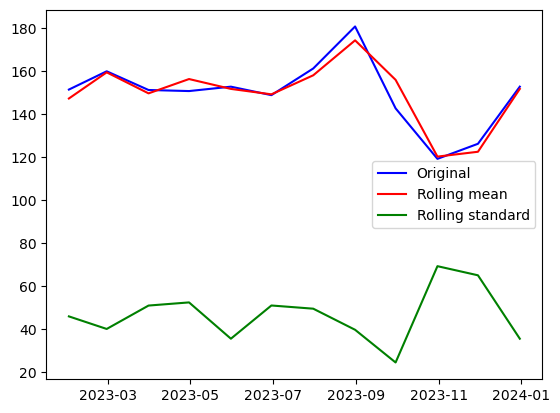

Result of Dickey-Fuller test
ADF statistics: -4.648065
p-value:   0.000105
Critical values
1% -3.449226932880019
5% -2.869857365438656
10% -2.571201085130664


In [45]:
#Applies the test_stationarity function to analyze and visualize the stationarity of the 'plot_a' our target variable time series.

test_stationarity(plot_a) 

In [46]:
def check_stationarity(p_value, alpha=0.05):
    """
    Check if a time series is stationary based on the p-value.
    
    Parameters:
    - p_value (float): The p-value from a stationarity test.
    - alpha (float): The significance level to compare the p-value against. Default is 0.05.
    
    Returns:
    - str: "Stationary" if the time series is stationary, otherwise "Non-Stationary".
    """
    if p_value < alpha:
        return "Stationary"
    else:
        return "Non-Stationary"

# Example usage:
p_value = 0.000105 # Replace with your actual p-value
result = check_stationarity(p_value)
print(result)

Stationary


In [47]:
#Data preparation
from feature_engine.outliers import Winsorizer


#Applies Winsorization to handle outliers in the specified columns ('temp_max', 'temp_min', 'wind', 'precipitation') using 
#the Winsorizer from the feature_engine library and plots boxplots for the transformed data.

<Axes: >

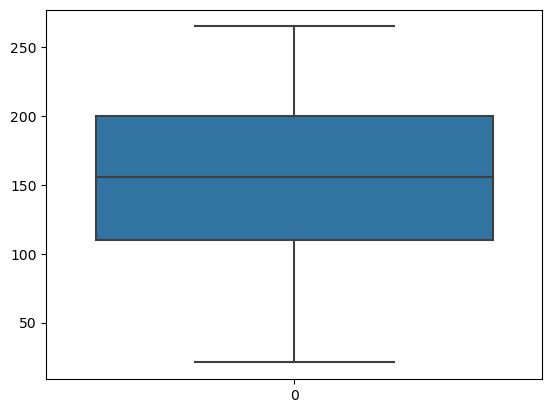

In [48]:
winsor=Winsorizer(capping_method='iqr',tail='both',fold=1.5,variables=['Total_Customer'])
df_t=winsor.fit_transform(df[['Total_Customer']]) 

sns.boxplot(df_t.Total_Customer)



In [49]:
#  Dropping Duplicate data 
df.drop_duplicates()

,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1,1,2023
2023-01-02,231,2,1,2023
2023-01-03,116,3,1,2023
2023-01-04,114,4,1,2023
2023-01-05,223,5,1,2023
...,...,...,...,...
2023-12-27,110,27,12,2023
2023-12-28,180,28,12,2023
2023-12-29,200,29,12,2023


In [50]:
df.isnull().sum()

Total_Customer    0
day               0
month             0
year              0
dtype: int64

In [51]:
#Builds an automated time series forecasting model using the AutoTS library for the 'Total_Customer' column in the DataFrame df, 
#split into training and test sets, and returns the model, model results, validation results, and forecast.


from autots import AutoTS

df["day"]=pd.to_datetime(df["Total_Customer"])  
def model_build(target):
    
    train = df2[0:100]
    test=df2[100:365]
    print(train.shape,test.shape)

    ts_column='Total_Customer'
    sep=','
  
    model = AutoTS(forecast_length=7,frequency='infer',prediction_interval=0.95,ensemble=None,model_list="fast",transformer_list="fast",drop_most_recent=1,max_generations=4,num_validations=2,validation_method="backwards")
    model = model.fit(train,date_col="day" ,value_col=target,id_col=None )
    
    # Predicting
    prediction = model.predict()
    forecast = pd.DataFrame(prediction.forecast)
    
    # plot a sample
    prediction.plot(model.df2_wide_numeric,
                    series=model.df2_wide_numeric.columns[0],
                    start_date=df2["day"].iloc[-7])
    
    # accuracy of all tried model results
    model_results = model.results()
    model_results = pd.DataFrame(model_results)
  
    # and aggregated from cross validation
    validation_results = model.results("validation")

    
    return model,model_results,validation_results,forecast
####

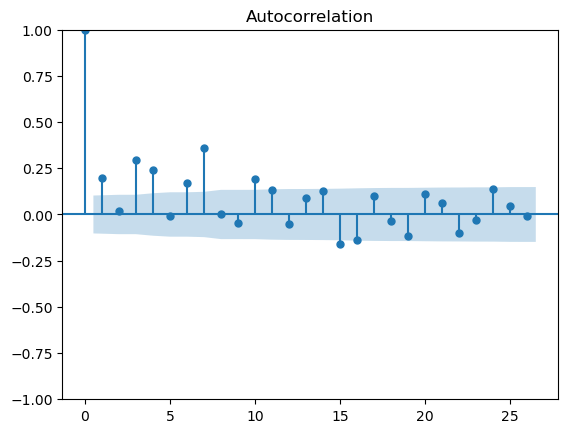

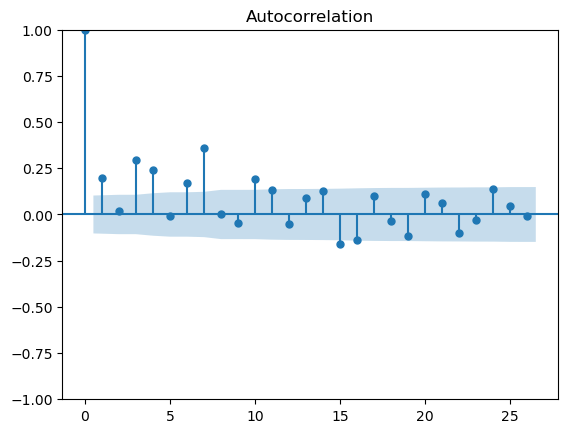

In [52]:
# Aplly ACF for plot_a means Total_Customer col
plot_acf(plot_a)


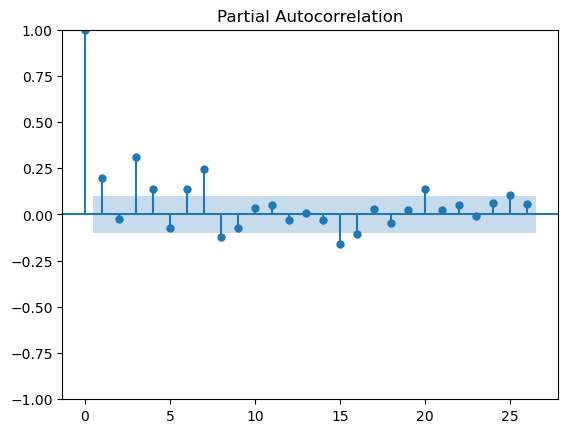

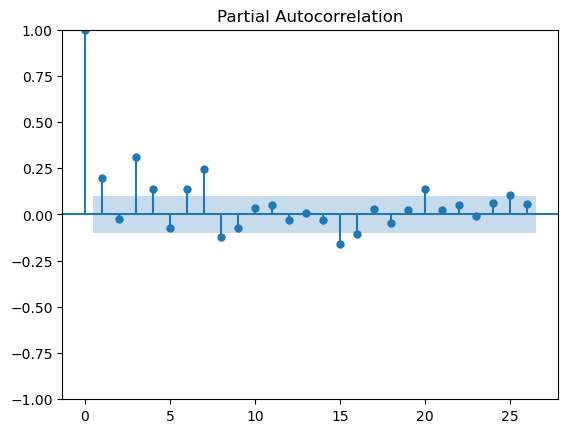

In [53]:
plot_pacf(plot_a)

In [54]:
def EDA():
    #analyzing the dataset
    eda_report=sv.analyze(df)
    #display the report
    eda_report.show_html('eda12.html')

In [55]:
# Example custom EDA transformer
class EDA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Perform EDA tasks like handling missing values, encoding, etc.
        return self
    
    def transform(self, X):
        # Apply the transformations
        return X

In [56]:

def model_build(target_column):
    class ModelBuilder(BaseEstimator):
        def __init__(self, target_column):
            self.target_column = target_column
            self.model = LinearRegression()  # Replace with your model of choice
        
        def fit(self, X, y):
            self.model.fit(X, y)
            return self
        
        def predict(self, X):
            return self.model.predict(X)
    
    return ModelBuilder(target_column)


In [57]:
# Create the pipeline
pipe = Pipeline([
    ("EDA", EDA()),
    ("Model", model_build("Total_Customer"))
])

In [58]:
df


,Total_Customer,day,month,year
Date,,,,
2023-01-01,198,1970-01-01 00:00:00.000000198,1,2023
2023-01-02,231,1970-01-01 00:00:00.000000231,1,2023
2023-01-03,116,1970-01-01 00:00:00.000000116,1,2023
2023-01-04,114,1970-01-01 00:00:00.000000114,1,2023
2023-01-05,223,1970-01-01 00:00:00.000000223,1,2023
...,...,...,...,...
2023-12-27,110,1970-01-01 00:00:00.000000110,12,2023
2023-12-28,180,1970-01-01 00:00:00.000000180,12,2023
2023-12-29,200,1970-01-01 00:00:00.000000200,12,2023


Best ARIMA parameters: (2, 1, 2) with AIC: 3078.838420000973
Root Mean Squared Error (RMSE): 65.31304677218816


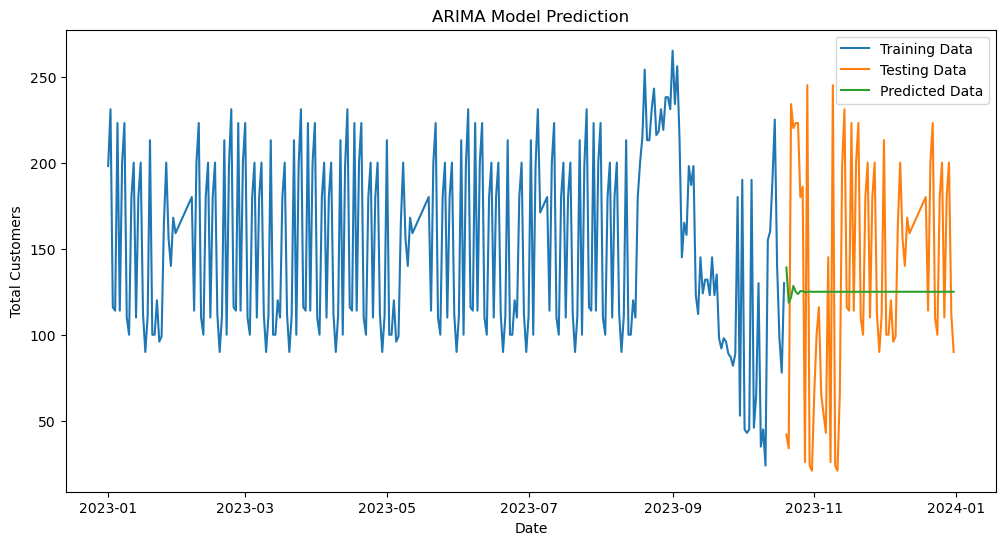

In [59]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'Date' is already set as the index, if not, set it as index
# df.set_index('Date', inplace=True)

# Splitting the data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% of data for training, 20% for testing
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Define ARIMA parameters
p = d = q = range(0, 3)  # Define the range for p, d, q parameters
# Generate all different combinations of p, d, q triplets
pdq = [(x, y, z) for x in p for y in d for z in q]

# Find the best parameters using AIC (Akaike Information Criterion)
best_aic = np.inf
best_pdq = None
best_model = None
for param in pdq:
    try:
        model = ARIMA(train_data['Total_Customer'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        print(f"Failed to fit ARIMA{param}: {e}")
        continue

if best_model is not None:
    print(f"Best ARIMA parameters: {best_pdq} with AIC: {best_aic}")

    # Make predictions on the test data
    predictions = best_model.forecast(steps=len(test_data))

    # Calculate RMSE (Root Mean Squared Error) to evaluate the model
    rmse = np.sqrt(mean_squared_error(test_data['Total_Customer'], predictions))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plotting the training, testing, and predicted data
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Total_Customer'], label='Training Data')
    plt.plot(test_data.index, test_data['Total_Customer'], label='Testing Data')
    plt.plot(test_data.index, predictions, label='Predicted Data')
    plt.title('ARIMA Model Prediction')
    plt.xlabel('Date')
    plt.ylabel('Total Customers')
    plt.legend()
    plt.show()

    


In [60]:
# Predicting future data for specific dates
future_dates = ['2024-06-09', '2024-06-10', '2024-06-11']  # Add dates you want to predict
future_predictions = best_model.forecast(steps=len(future_dates))

for date, pred in zip(future_dates, future_predictions):
    print(f"Prediction for {date}: {pred}")
else:
    print("No valid ARIMA model found.")

Prediction for 2024-06-09: 139.06323456446836
Prediction for 2024-06-10: 118.53137710859347
Prediction for 2024-06-11: 121.75682065739251
No valid ARIMA model found.


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
test_result=adfuller(df['Total_Customer'])

In [63]:
# Importing necessary libraries
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis, indicating it is non-stationary.")

adfuller_test(df['Total_Customer'])


ADF Test Statistic : -4.648064705319995
p-value : 0.00010523427646773139
#Lags Used : 15
Number of Observations : 349
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


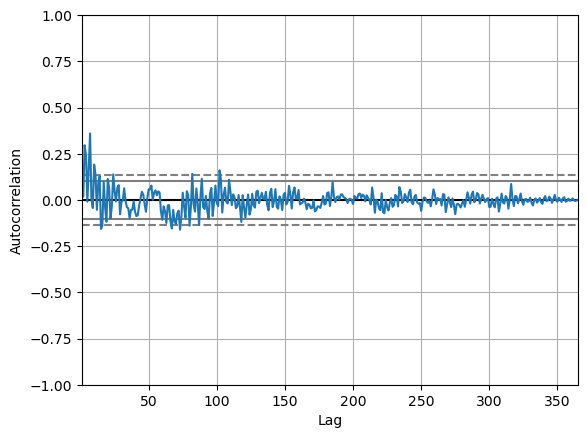

In [64]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Total_Customer'])
plt.show()

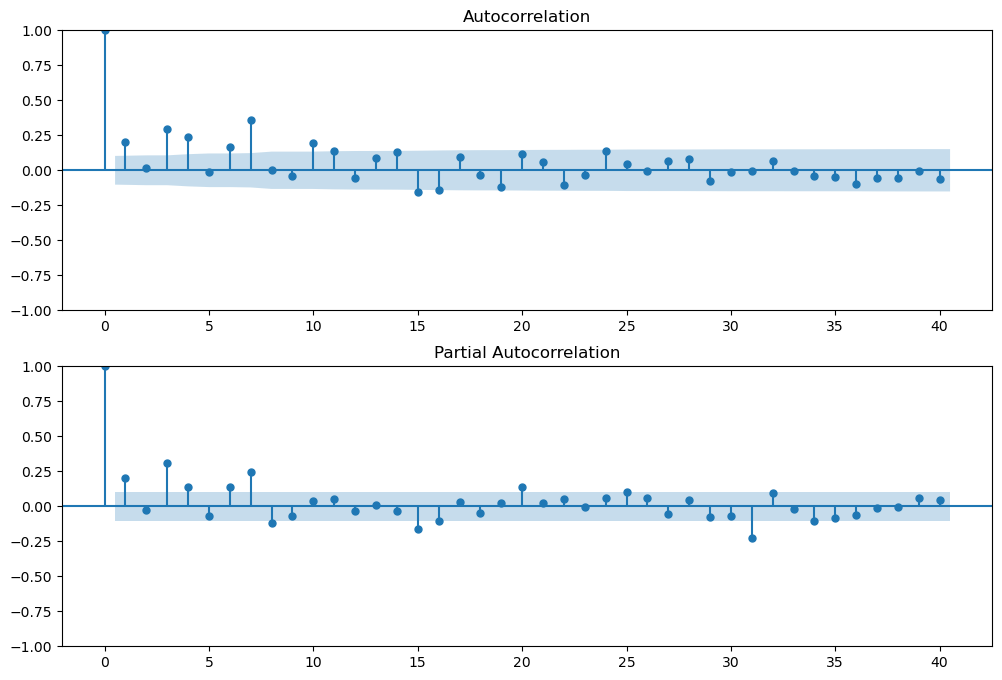

In [65]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Total_Customer'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Total_Customer'].dropna(),lags=40,ax=ax2)


# SARIMA Model

<Axes: xlabel='Date'>

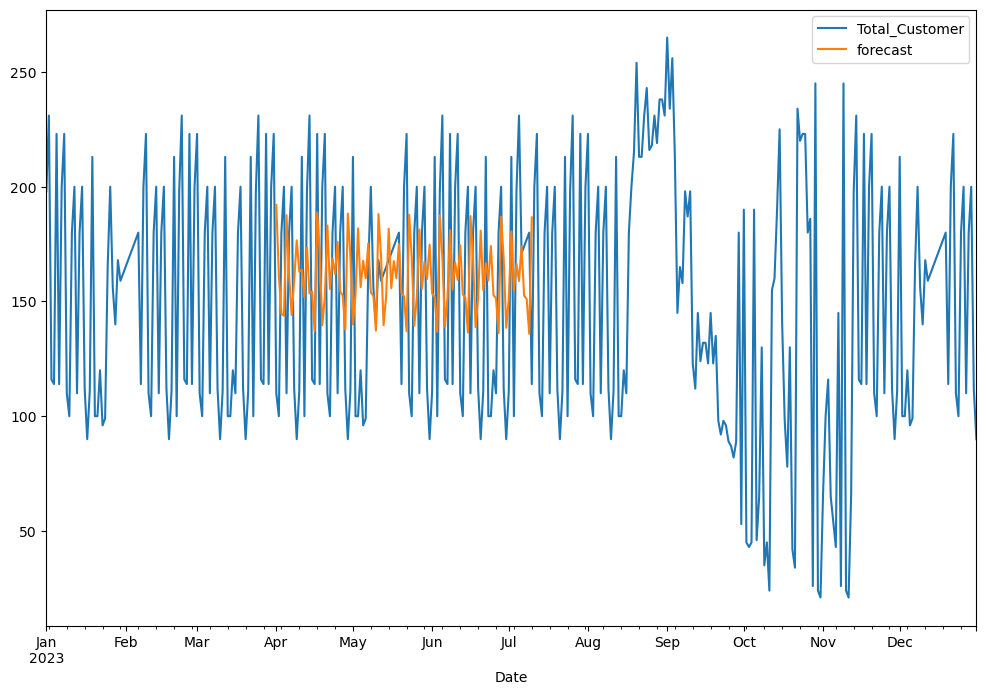

In [66]:


import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Total_Customer'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=90,end=190,dynamic=True)
df[['Total_Customer','forecast']].plot(figsize=(12,8))

In [67]:
print(df['Total_Customer'].iloc[90:190])

Date
2023-04-01    110
2023-04-02    100
2023-04-03    180
2023-04-04    200
2023-04-05    110
             ... 
2023-07-05    231
2023-07-06    171
2023-07-07    174
2023-07-08    177
2023-07-09    180
Name: Total_Customer, Length: 100, dtype: int64


In [68]:
df['forecast'].iloc[90:190]

Date
2023-04-01    192.087753
2023-04-02    161.417693
2023-04-03    144.633207
2023-04-04    143.789462
2023-04-05    187.606057
                 ...    
2023-07-05    158.921232
2023-07-06    173.897780
2023-07-07    152.522986
2023-07-08    151.057574
2023-07-09    135.913531
Name: forecast, Length: 100, dtype: float64

In [69]:
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     Total_Customer   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1917.892
Date:                            Sat, 08 Jun 2024   AIC                           3845.784
Time:                                    14:47:22   BIC                           3865.102
Sample:                                01-01-2023   HQIC                          3853.471
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0604      0.053      1.146      0.252      -0.043       0.164
ma.L1         -0.8747      0.030   

In [71]:
def forecast_next_7_days(user_date, model):
    # Convert user input into a pandas DateTime object
    user_date = pd.to_datetime(user_date, format='%d-%m-%Y')

    # Generate forecast dates for the next 7 days
    forecast_dates = pd.date_range(start=user_date, periods=1, freq='D')

    # Forecast next 7 days
    forecast = model.predict(start=forecast_dates[0], end=forecast_dates[-1], dynamic=True)

    # Create a DataFrame to store the forecast
    forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecast'])

    # Add the forecasted values to the DataFrame
    forecast_df['Forecast'] = forecast

    return forecast_df

# Example usage:
user_input = input("Enter a date (in the format dd-mm-yyyy): ")
forecast1 = forecast_next_7_days(user_input, results)


print(forecast1.astype(int))

Enter a date (in the format dd-mm-yyyy): 01-12-2024
            Forecast
2024-12-01       145


## Benifits to Clients 

### Enhanced revenue management: Optimized resource allocation leads to increased revenue generation opportunities and profitability.

### Better inventory management: Efficient resource utilization prevents stockouts and wastage, enhancing operational efficiency.
### Fostering a data-driven decision culture: Utilizing data insights promotes informed strategic decisions, improving overall project outcomes.